#### Import all the required libraries

In [70]:
import pandas as pd
import os
import networkx as nx
import itertools
from netwulf import visualize
import netwulf as nw
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

#### Read the dataset into dataframe

In [71]:
author_df = pd.read_csv("salt_cont_author.csv")
article_list = pd.read_csv(r"article_list.csv")
author_df.head()

,ID,title,author_given_name,author_surname,author_id,organizational_author,manual
0,1,Systematic review of long term effects of advi...,Lee,Hooper,57202855325,NaN,False
1,1,Systematic review of long term effects of advi...,Christopher,Bartlett,57194377301,NaN,False
2,1,Systematic review of long term effects of advi...,George Davey,Smith,35354080500,NaN,False
3,1,Systematic review of long term effects of advi...,Shah,Ebrahim,7102093023,NaN,False
4,2,Reduced dietary salt for prevention of cardiov...,L.,Hooper,57202855325,NaN,False


In [72]:
article_list.study_design.unique()

array(['Systematic Review', 'RCT', 'Cohort', 'Case Control'], dtype=object)

#### New column in the dataframe for author full_name. Replace the names of author with similar id to the selected key (author name) in the dictionary

In [73]:
author_df["full_name"] = author_df['author_given_name'] + " " + author_df['author_surname'].fillna('')
author_df.head()

list_authors  = pd.DataFrame(author_df.groupby('author_id')['full_name'].apply(list))
auth_list = list_authors.full_name.to_list()

auth_dict = dict()

for i in auth_list:
    i = list(set(i))
    if len(i) > 1:
        auth_dict[i[0]] = i[1:]

#### Function replaces the names of author with same id with the selected key in the dictionary
def replace(auth_name, final_dict):
    for k, v in final_dict.items():
        if auth_name in v:
            auth_name = k
            
    return auth_name
    

author_df.full_name = author_df.full_name.apply(lambda x : replace (x, auth_dict))
com_df = pd.DataFrame(author_df.groupby('ID')['full_name'].apply(list))

In [74]:
com_df.head()

,full_name
ID,
1,"[L. Hooper, Christopher Bartlett, G. Davey Smi..."
2,"[L. Hooper, Christopher Bartlett, G. Davey Smi..."
3,"[L. Hooper, Christopher Bartlett, G. Davey Smi..."
4,"[Pasquale Strazzullo, Lanfranco D'Elia, Ngiang..."
5,"[RS Taylor, Kate E. Ashton, Tiffany Moxham, L...."


#### Check if the author full name is similar in each occurence of the author id 

In [75]:
author_df[author_df.author_id == 57202855325]

,ID,title,author_given_name,author_surname,author_id,organizational_author,manual,full_name
0,1,Systematic review of long term effects of advi...,Lee,Hooper,57202855325,NaN,False,L. Hooper
4,2,Reduced dietary salt for prevention of cardiov...,L.,Hooper,57202855325,NaN,False,L. Hooper
8,3,Advice to reduce dietary salt for prevention o...,Lee,Hooper,57202855325,NaN,False,L. Hooper
19,5,Reduced dietary salt for the prevention of car...,Lee,Hooper,57202855325,NaN,False,L. Hooper
27,9,Effect of lower sodium intake on health: syste...,Lee,Hooper,57202855325,NaN,False,L. Hooper
449,6,Reduced dietary salt for the prevention of car...,Lee,Hooper,57202855325,NaN,False,L. Hooper


#### Get the number of publications by each author. 
- Current Threshold - list of author names who have more than three publications

In [76]:
auth_public = []
publications = author_df.groupby("full_name")["title"].count().to_dict()

# Change the number of publications i.e v >= 3 (3 articles as current threshold)
for k, v in publications.items():
    if v >= 3:
        auth_public.append(k)
        
#auth_public[:5]

In [77]:
# Merge the two dataframes to get the title and type of each publication

merged_type_df = pd.merge(com_df, article_list, how = "inner", left_on="ID", right_on="ID")
merged_type_df = merged_type_df[["ID", "full_name","title", "type",]]
merged_type_df.rename(columns={"Our ID":"ID", "type":"item_type", "Title" :"title"}, inplace=True)

# Co-author tuples along with type of the publications the authors worked together for 
new  = []
for i in range(1,len(merged_type_df["ID"])):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                new.append({"auth":subset, "type":type_t})
                
df = pd.DataFrame(new)

# Calculate the review percent 
# i.e. if the pair of authors mostly worked together on systematic review articles or others( 'RCT', 'Cohort', 'Case Control')
new  = {}
r_count = 0
i_count = 0
for i in range(1,len(merged_type_df)):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if type_t == "Systematic Review":
        r_count = 1
    else:
        i_count = 1
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                
                subset = tuple(sorted(subset))
                
                if subset not in new.keys():
                    new[subset] = (r_count, i_count)
                else:
                    new[subset] = (new[subset][0] + r_count, new[subset][1] + i_count)
                    
#                 new.append({"auth":subset, "type":type_t})

# Dataframe with the author group, count of each systematic review or other article and the systematic review percent
df = pd.DataFrame(new.items(), columns=['authors','counts'])
df[['reviews', 'other']] = pd.DataFrame(df['counts'].tolist(), index=df.index)
df[['auth_1', "auth_2"]] = pd.DataFrame(df['authors'].tolist(), index = df.index)
df['total'] = df['reviews'] + df['other']
df['review_percent'] = round(df['reviews']/df['total'] ,3)

In [78]:
no_publication_list = []
for i, row in df.iterrows():
    if row['auth_1'] in auth_public or row['auth_2'] in auth_public:
        no_publication_list.append(row)
        
df_publication = pd.DataFrame(no_publication_list)
df_publication.head()

,authors,counts,reviews,other,auth_1,auth_2,total,review_percent
0,"(Christopher Bartlett, L. Hooper)","(2, 0)",2,0,Christopher Bartlett,L. Hooper,2,1.0
1,"(G. Davey Smith, L. Hooper)","(2, 0)",2,0,G. Davey Smith,L. Hooper,2,1.0
2,"(L. Hooper, Shah Ebrahim)","(4, 0)",4,0,L. Hooper,Shah Ebrahim,4,1.0
3,"(Christopher Bartlett, G. Davey Smith)","(2, 0)",2,0,Christopher Bartlett,G. Davey Smith,2,1.0
4,"(Christopher Bartlett, Shah Ebrahim)","(2, 0)",2,0,Christopher Bartlett,Shah Ebrahim,2,1.0


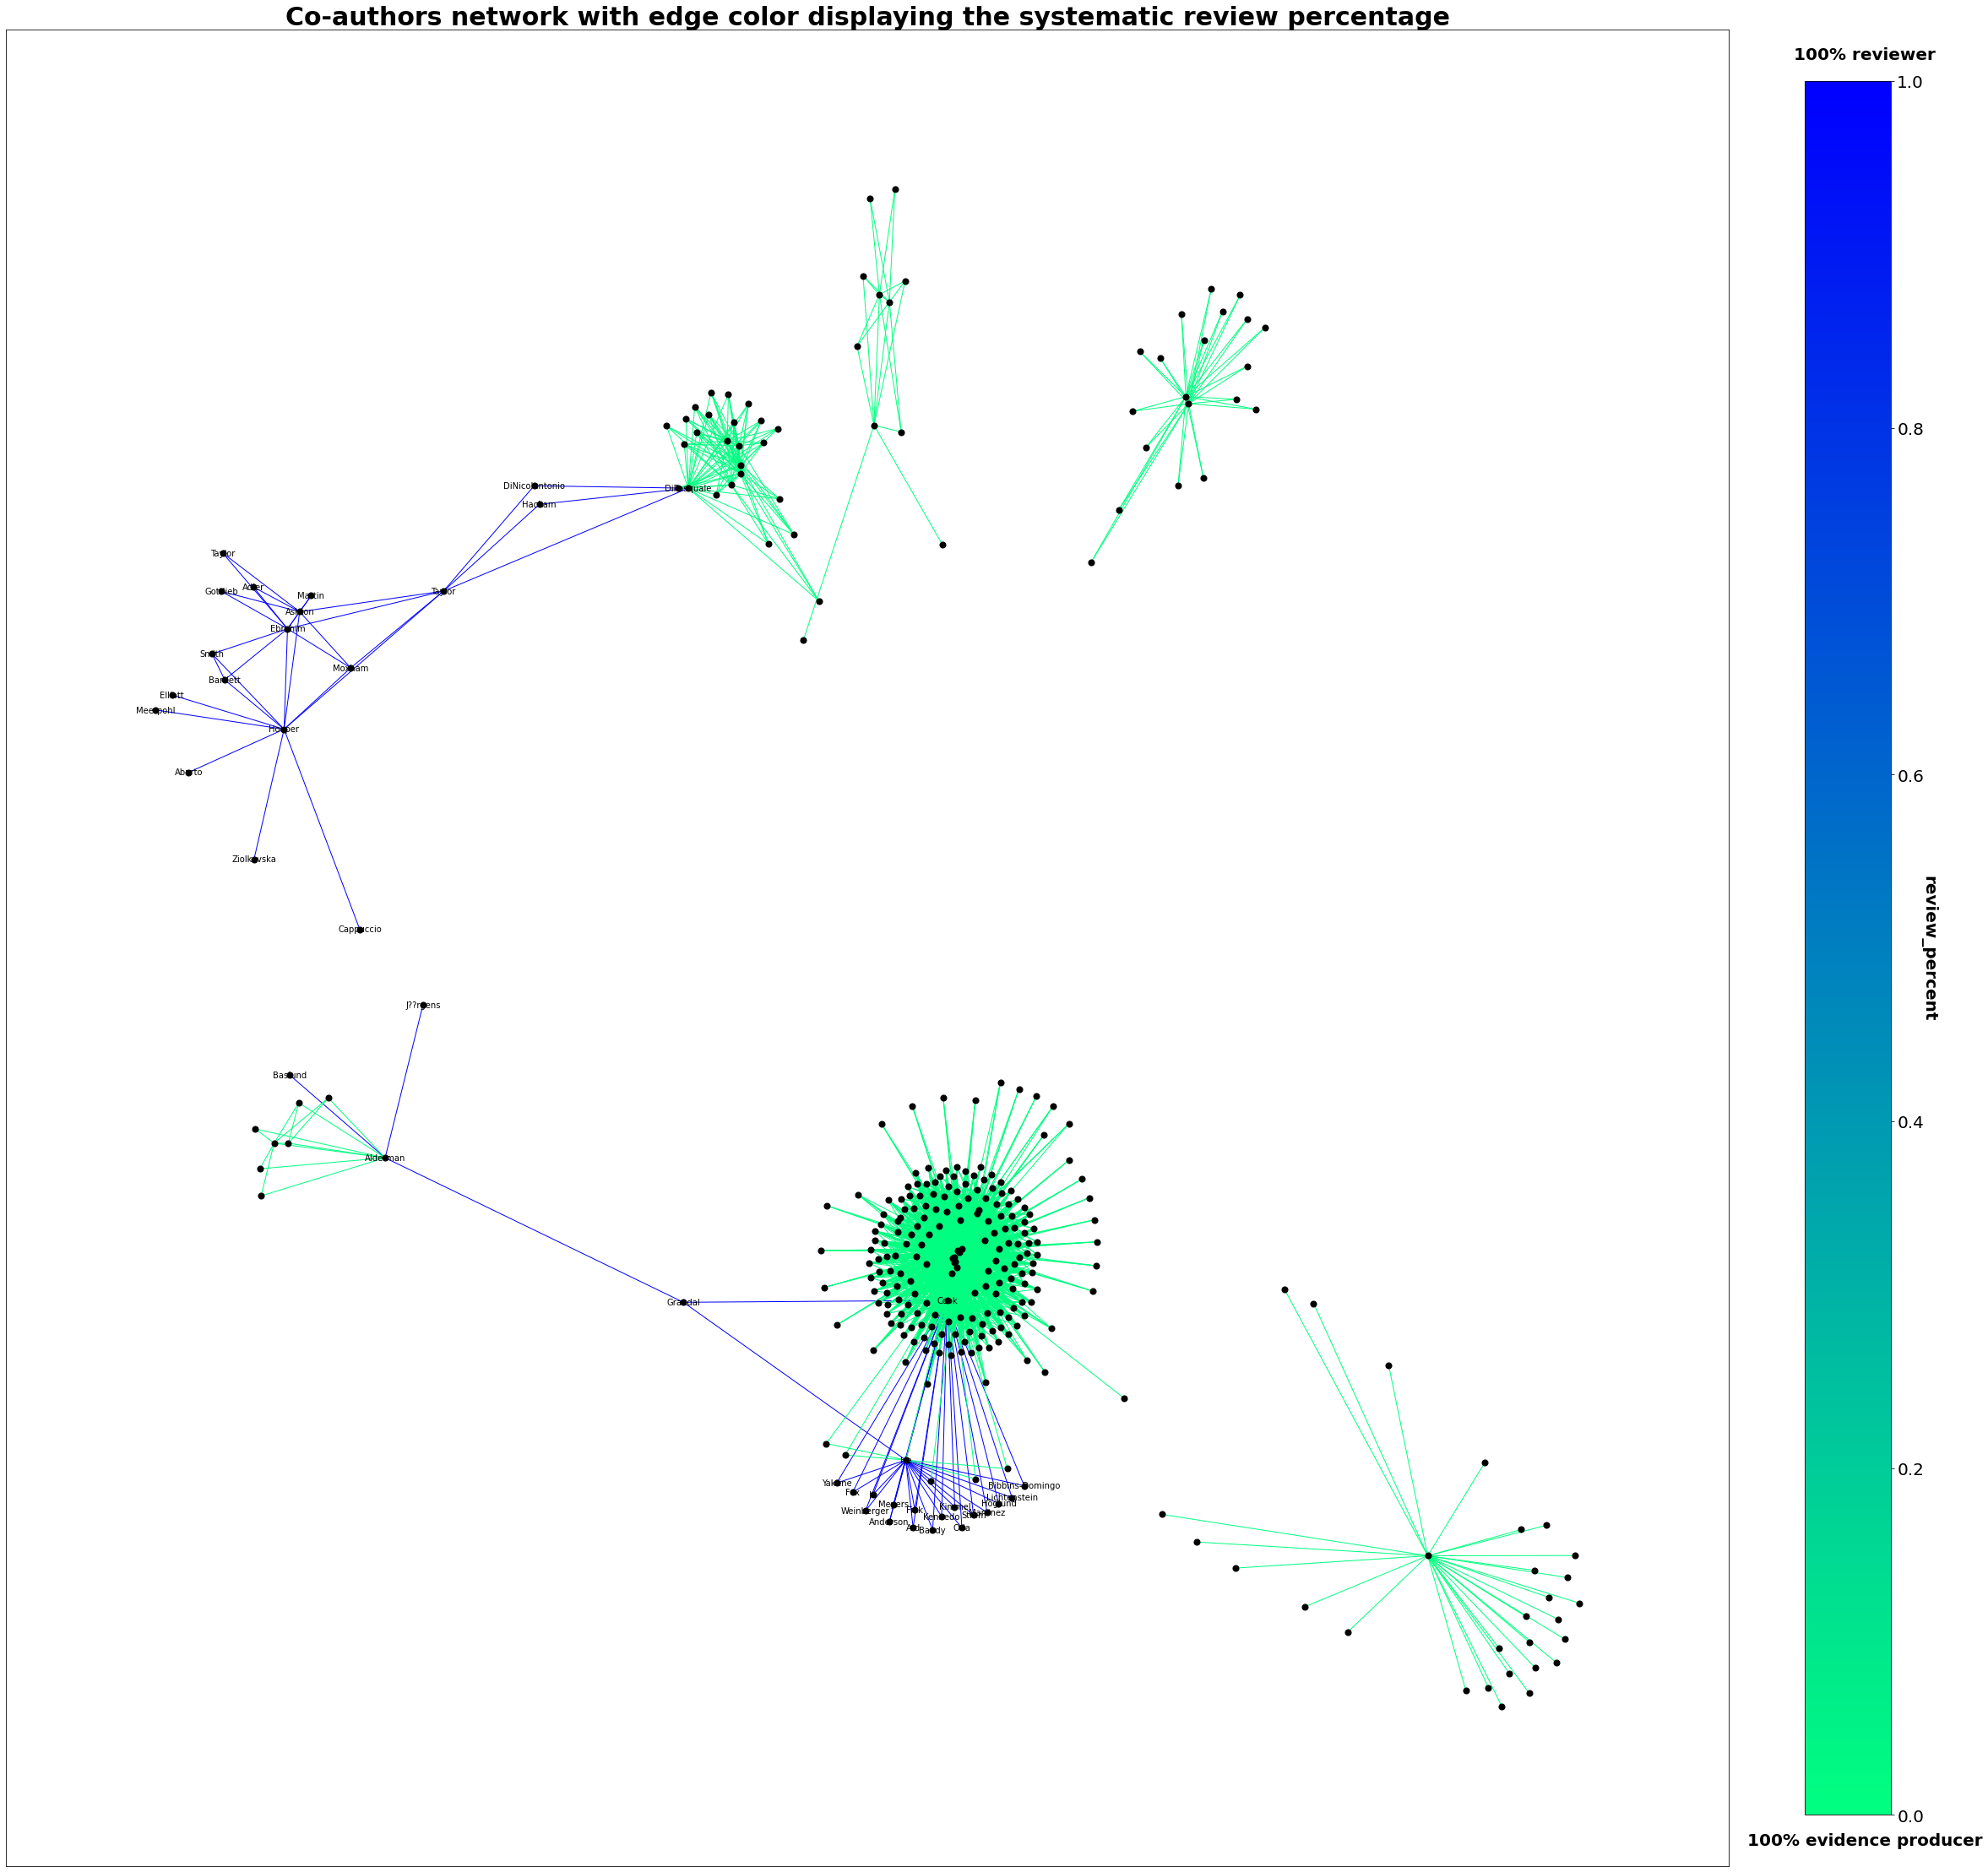

In [79]:
G = nx.from_pandas_edgelist(df_publication, "auth_1", "auth_2", edge_attr='review_percent', create_using=nx.Graph())

# Label nodes for authors who have higher published systematic reviews

label_nodes = []

for e in G.edges():
    if G.get_edge_data(e[0],e[1])['review_percent'] >= 0.9:
        label_nodes.append(e[0])
        label_nodes.append(e[1])

label_nodes = list(set(label_nodes))
label_nodes

labels = {}

for node in G.nodes():
    if node in label_nodes:
        labels[node] = node.split(" ")[-1]

edges,weights = zip(*nx.get_edge_attributes(G,'review_percent').items())
    
pos = nx.spring_layout(G,scale = 100, k = 0.11)
nodes = nx.draw_networkx_nodes(G, pos=pos,node_size = 50, node_color="black")
edges_1 = nx.draw_networkx_edges(G,pos=pos, edgelist=edges, edge_color=weights,  edge_cmap=plt.cm.winter_r)
nx.draw_networkx_labels(G, pos,labels,font_size=10,font_color='black')


plt.sci(edges_1)
plt.clim(0.0,1.0)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('review_percent', rotation=270,size=20,weight='bold' )
cbar.ax.text(0.7, -0.01, '100% evidence producer', va='top', ha='center', size=20, weight='bold')
cbar.ax.text(0.7, 1.02, '100% reviewer', va='top', ha='center', size=20, weight='bold')


plt.title("Co-authors network with edge color displaying the systematic review percentage", size = 30, weight = 'bold')
plt.rcParams["figure.figsize"] = [40, 40]
plt.rcParams["figure.autolayout"] = False

plt.savefig(r"C:\Users\mansj\IQL\salt\Coauthor Network Visualization\Visualizations\edge_color_pub_count.pdf", dpi = 800)

#### Systematic review article for individual author 
#### Node color displays the review percent for each author

In [80]:
new_auth  = {}
r_count = 0
i_count = 0
for i in range(1,len(merged_type_df)):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if type_t == "Systematic Review":
        r_count = 1
    else:
        i_count = 1
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                
                subset = tuple(sorted(subset))
                for i in subset:
                    if i not in new_auth.keys():
                        new_auth[i] = (r_count, i_count)
                    else:
                        new_auth[i] = (new_auth[i][0] + r_count, new_auth[i][1] + i_count)
                    

df_new = pd.DataFrame(new_auth.items(), columns=['authors','counts'])
df_new[['sys_reviews', 'others']] = pd.DataFrame(df['counts'].tolist(), index=df.index)

df_new['total'] = df_new['sys_reviews'] + df_new['others']
df_new['review'] = round(df_new['sys_reviews']/df_new['total'],2)

df_attr_node = df_new[['authors','review']]
node_attr = df_attr_node.set_index('authors').to_dict('index')
nx.set_node_attributes(G, node_attr, name = "review_percent")

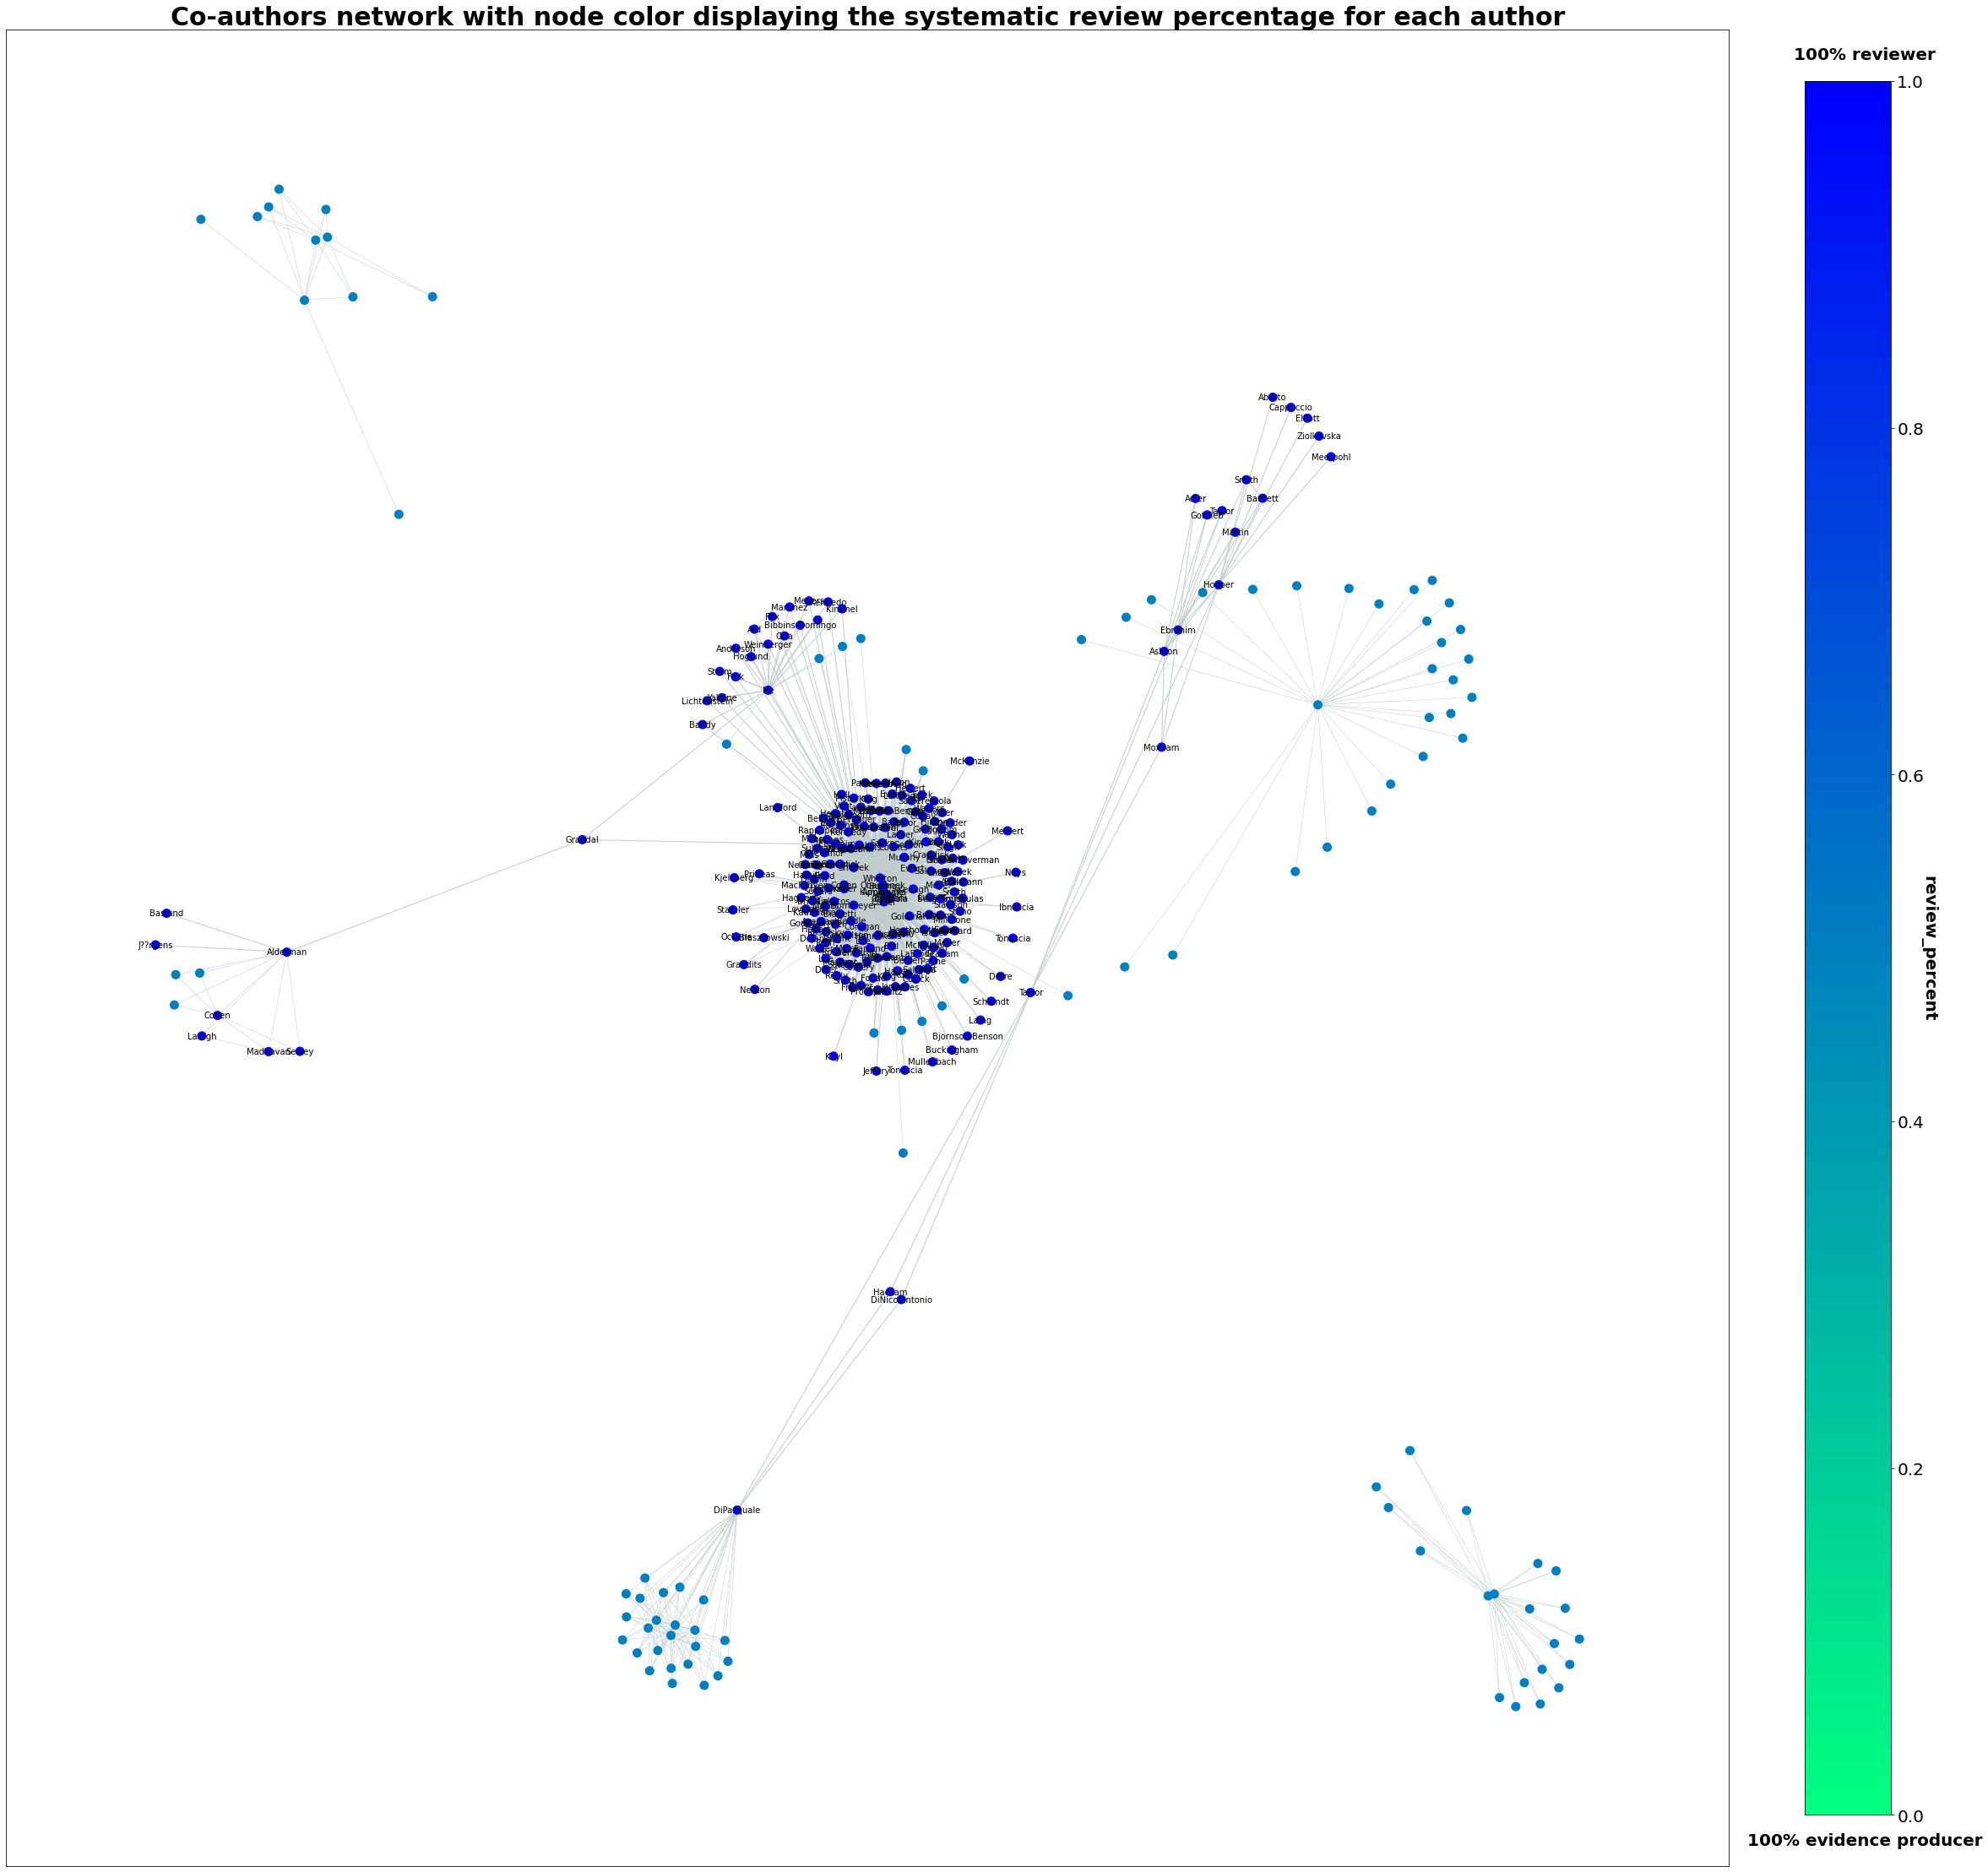

In [81]:
label_nodes = []

for n in G.nodes():
    if G.nodes[n]["review_percent"]['review'] >= 0.8:
        label_nodes.append(n)

label_nodes = list(set(label_nodes))
label_nodes

labels = {}

for node in G.nodes():
    if node in label_nodes:
        labels[node] = node.split(" ")[-1]

edges,weights = zip(*nx.get_edge_attributes(G,'review_percent').items())
nodes, r_pct = zip(*nx.get_node_attributes(G,'review_percent').items())

node_weight = []
for r in r_pct:
    node_weight.append(r['review'])

pos = nx.spring_layout(G, scale = 100, k = 0.1)
nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_size=100, node_color=node_weight, cmap = plt.cm.winter_r)
edges_1 = nx.draw_networkx_edges(G,pos=pos, node_size = 10, width=weights, edgelist=edges, edge_color = '#C1CDCD')
nx.draw_networkx_labels(G, pos,labels,font_size=10,font_color='black')

plt.sci(nodes)
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(0.0,1.0)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('review_percent', rotation=270,size=20,weight='bold' )
cbar.ax.text(0.7, -0.01, '100% evidence producer', va='top', ha='center', size=20, weight='bold')
cbar.ax.text(0.7, 1.02, '100% reviewer', va='top', ha='center', size=20, weight='bold')

plt.title("Co-authors network with node color displaying the systematic review percentage for each author", size = 30, weight = 'bold')

plt.rcParams["figure.figsize"] = [40, 40]
plt.rcParams["figure.autolayout"] = False

plt.savefig(r"C:\Users\mansj\IQL\salt\Coauthor Network Visualization\Visualizations\node_color_pub_count.pdf", dpi = 800)
